In [ ]:
#import libraries
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report # Import the classification_report function
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay # Import ConfusionMatrixDisplay
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv3D, MaxPooling3D, Flatten, Dropout, BatchNormalization
import numpy as np
import os
import matplotlib.pyplot as plt
from pathlib import Path
%matplotlib inline


In [ ]:
#Loading data...

# Define the file paths
videos = np.load('/content/drive/MyDrive/DataCollected/allVideoFrames.npy')
labels = np.load('/content/drive/MyDrive/DataCollected/allLabels.npy')

labels[400:404] = 'f' #Error correction from data collection


# Verify files shape
print(videos.shape)
print(labels.shape)

(600, 20, 80, 80)
(600,)


In [ ]:
labels_dict = {
    'a': 0,
    'b': 1,
    'c': 2,
    'd': 3,
    'f': 4,
    'j': 5,
}


# Convert labels to numerical values
labels_num = [labels_dict[l] for l in labels]

labels = np.array(labels_num)

In [ ]:
#Randomly splitting trainging data and testing data
X_train, X_test, Y_train, Y_test = train_test_split(videos, labels, test_size=0.2, random_state=7)

#Resize to be 3d
X_train_reshaped = np.reshape(X_train, (480, 20, 80, 80, 1))
X_test_reshaped = np.reshape(X_test, (120, 20, 80, 80, 1))
X_train = X_train_reshaped
X_test = X_test_reshaped

print(f"X_train shape: {X_train.shape}")
print(f"Y_train shape: {Y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"Y_test shape: {Y_test.shape}")



X_train shape: (480, 20, 80, 80, 1)
Y_train shape: (480,)
X_test shape: (120, 20, 80, 80, 1)
Y_test shape: (120,)


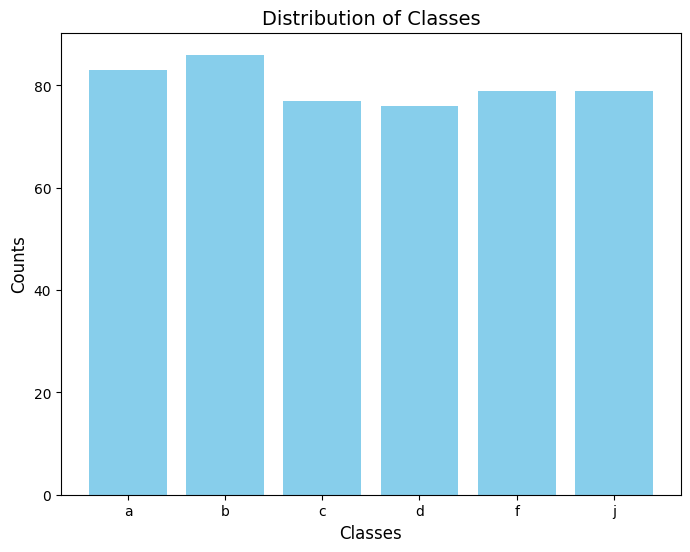

In [ ]:
#Count labels within dataset and assess distribution of dataset
unique_values, label_counts = np.unique(Y_train, return_counts=True)
x_labels = ['a', 'b', 'c', 'd', 'f', 'j']

# Plotting distribution histogram
plt.figure(figsize=(8, 6))
plt.bar(x_labels, label_counts, color='skyblue')
plt.xlabel('Classes', fontsize=12)
plt.ylabel('Counts', fontsize=12)
plt.title('Distribution of Classes', fontsize=14)


# Show plot
plt.show()

In [ ]:
# Transform answers into one-hotencoding
y_categorical_train = to_categorical(Y_train, 6)
y_categorical_test = to_categorical(Y_test, 6)

In [ ]:
#Model architecture

input_shape = (20, 80, 80, 1)
kernel_size = (3, 3, 3)
lambda_val = lambda: 0.002

#create model
model = Sequential()

#Convolutional Layers

#Block 1
model.add(Conv3D(filters=64, kernel_size=kernel_size, input_shape=input_shape, activation='relu', padding='same', kernel_regularizer=l2(lambda_val())))
model.add(BatchNormalization())
model.add(MaxPooling3D((2, 2, 2)))


# Block 2
model.add(Conv3D(filters=128, kernel_size=kernel_size, input_shape=input_shape, activation='relu', padding='same', kernel_regularizer=l2(lambda_val())))
model.add(BatchNormalization())
model.add(MaxPooling3D((2, 2, 2)))


# Block 3
model.add(Conv3D(filters=256, kernel_size=kernel_size, input_shape=input_shape, activation='relu', padding='same', kernel_regularizer=l2(lambda_val())))
model.add(BatchNormalization())
model.add(MaxPooling3D((2, 2, 2)))


# Flatten and fully connected layers
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(6, activation='softmax'))

#compile model
eval_metrics = [
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=eval_metrics)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 20, 80, 80, 64)    1792      
                                                                 
 batch_normalization (Batch  (None, 20, 80, 80, 64)    256       
 Normalization)                                                  
                                                                 
 max_pooling3d (MaxPooling3  (None, 10, 40, 40, 64)    0         
 D)                                                              
                                                                 
 conv3d_1 (Conv3D)           (None, 10, 40, 40, 128)   221312    
                                                                 
 batch_normalization_1 (Bat  (None, 10, 40, 40, 128)   512       
 chNormalization)                                                
                                                        

In [ ]:
#training model
batchsize_parameter = 32
epochs_parameter = 15

#fit model

history = model.fit(X_train, y_categorical_train, epochs=epochs_parameter, batch_size=batchsize_parameter, validation_data=(X_test, y_categorical_test))

Epoch 1/15
15/15 [==============================] - 28s 1s/step - loss: 42.9159 - accuracy: 0.2896 - precision: 0.2893 - recall: 0.2875 - val_loss: 279.1914 - val_accuracy: 0.2917 - val_precision: 0.2917 - val_recall: 0.2917
Epoch 2/15
15/15 [==============================] - 4s 282ms/step - loss: 13.9553 - accuracy: 0.5146 - precision: 0.5146 - recall: 0.5146 - val_loss: 32.4036 - val_accuracy: 0.3750 - val_precision: 0.3750 - val_recall: 0.3750
Epoch 3/15
15/15 [==============================] - 4s 287ms/step - loss: 7.5121 - accuracy: 0.6687 - precision: 0.6687 - recall: 0.6687 - val_loss: 42.3355 - val_accuracy: 0.3417 - val_precision: 0.3445 - val_recall: 0.3417
Epoch 4/15
15/15 [==============================] - 4s 282ms/step - loss: 5.2080 - accuracy: 0.7542 - precision: 0.7573 - recall: 0.7542 - val_loss: 13.0806 - val_accuracy: 0.4333 - val_precision: 0.4333 - val_recall: 0.4333
Epoch 5/15
15/15 [==============================] - 4s 282ms/step - loss: 4.4005 - accuracy: 0.7396

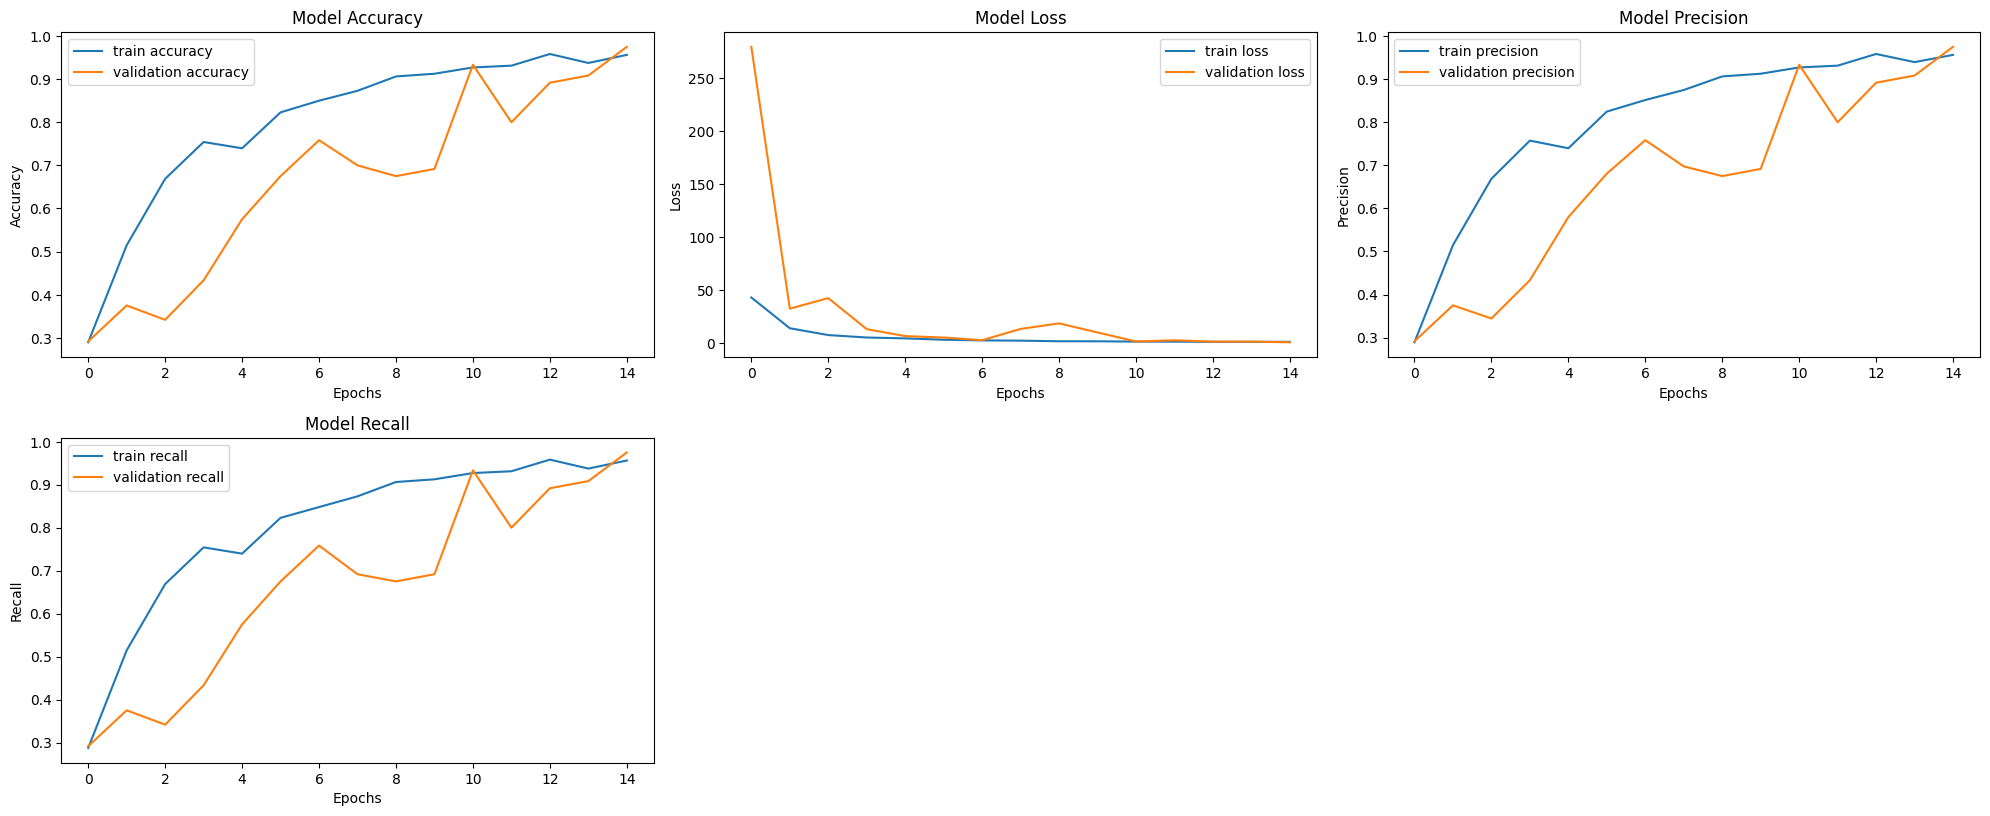

In [ ]:
#plotting metrics for model hyperparameter tuning

plt.figure(figsize = (20,20))

#Accuracy plot
plt.subplot(5,3,1)
plt.plot(history.history['accuracy'], label= 'train accuracy')
plt.plot(history.history['val_accuracy'], label= 'validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.title('Model Accuracy')
plt.legend()

#Loss plot
plt.subplot(5,3,2)
plt.plot(history.history['loss'], label= 'train loss')
plt.plot(history.history['val_loss'], label= 'validation loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.title('Model Loss')
plt.legend()


#Precision plot
plt.subplot(5,3,3)
plt.plot(history.history['precision'], label= 'train precision')
plt.plot(history.history['val_precision'], label= 'validation precision')
plt.ylabel('Precision')
plt.xlabel('Epochs')
plt.title('Model Precision')
plt.legend()

#Precision plot
plt.subplot(5,3,4)
plt.plot(history.history['recall'], label= 'train recall')
plt.plot(history.history['val_recall'], label= 'validation recall')
plt.ylabel('Recall')
plt.xlabel('Epochs')
plt.title('Model Recall')
plt.legend()

plt.tight_layout()
plt.show()



In [ ]:
#Saving model weights
model.save_weights('model_weights.h5')

4/4 [==============================] - 0s 74ms/step - loss: 0.7078 - accuracy: 0.9750 - precision: 0.9750 - recall: 0.9750
Loss: 0.7077874541282654
Accuracy: 0.9750000238418579
Precision: 0.9750000238418579
Recall: 0.9750000238418579
4/4 [==============================] - 0s 74ms/step


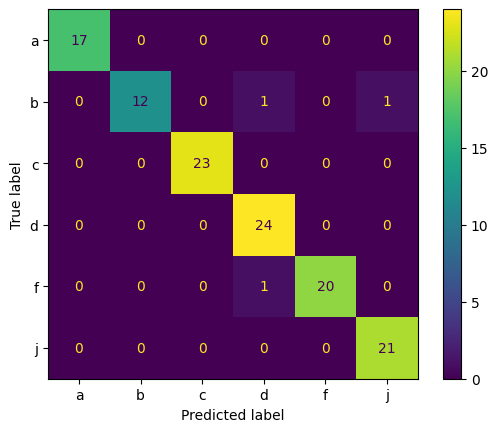

In [ ]:
#Evaluating the model

evaluation = model.evaluate(X_test, y_categorical_test)


print(f"Loss: {evaluation[0]}")
print(f"Accuracy: {evaluation[1]}")
print(f"Precision: {evaluation[2]}")
print(f"Recall: {evaluation[3]}")

#Making a confusion matrix
Y_predict = model.predict(X_test)
Y_predict = np.argmax(Y_predict, axis=1)

cm = confusion_matrix(Y_test, Y_predict)

plot = ConfusionMatrixDisplay(cm, display_labels=['a', 'b', 'c', 'd', 'f', 'j'])
plot.plot()
plt.show()


In [ ]:
#Classification report

print(classification_report(Y_test, Y_predict))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        17
           1       1.00      0.86      0.92        14
           2       1.00      1.00      1.00        23
           3       0.92      1.00      0.96        24
           4       1.00      0.95      0.98        21
           5       0.95      1.00      0.98        21

    accuracy                           0.97       120
   macro avg       0.98      0.97      0.97       120
weighted avg       0.98      0.97      0.97       120

